In [1]:
import numpy as np
from numpy import random as rd
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import acf
from ito_diffusion_1d import *
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
plt.style.use('dark_background')

In [2]:
params = {
    'font.size': 14,
    'figure.figsize': (11,18),
    'axes.labelsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
}
plt.rcParams.update(params)

In [3]:
def RPRG(df, random=rd.uniform, random_state=None):
    """Random Phase Returns Generator
    Takes a time series, 
    1) calculate the returns
    2) move them to Fourier space
    3) scramble the phases
    4) move back from Fourier space
    Returns the cumulative returns series starting from the same initial point.
    """
    start = df.values[0,0]
    # set random seed
    np.random.seed(random_state)
    # Operate on numpy.ndarray
    rets = ((df-df.shift(1))/df.shift(1)).iloc[1:].values
    # Odd number of samples
    if len(rets) % 2 != 0:
        rets = rets[1:, :]

    rets = rets[:,0]
    rets_gen = np.empty_like(rets)
    # Fourier Transaformation (real-valued signal)
    F_rets = np.fft.rfft(rets)
    # scramble the phase
    rv_phase = np.exp(random(0, np.pi, len(F_rets)) * 1.0j)
    F_rets_new = F_rets * rv_phase
    # Inverse Fourier Transformation
    rets_gen = np.fft.irfft(F_rets_new)
    # Create pandas DataFrame
    rets_gen = pd.DataFrame(rets_gen, columns=df.columns, index=df.index[-len(rets_gen):])
    
    df_gen = np.cumprod(rets_gen+1, 0)*start
    df_gen.loc[0]=start
    df_gen.sort_index(inplace=True)
    
    return df_gen

In [4]:
T = 1
SCHEME_STEPS = 500
LAGS = 10
N_SURRROGATE = 5

## Brownian motion, with and without drift

Again, scrambling the phase of returns in Fourier space does not affect the autocorrelogram. The resulting sample paths are similar in volatility, although their drifts have changed.

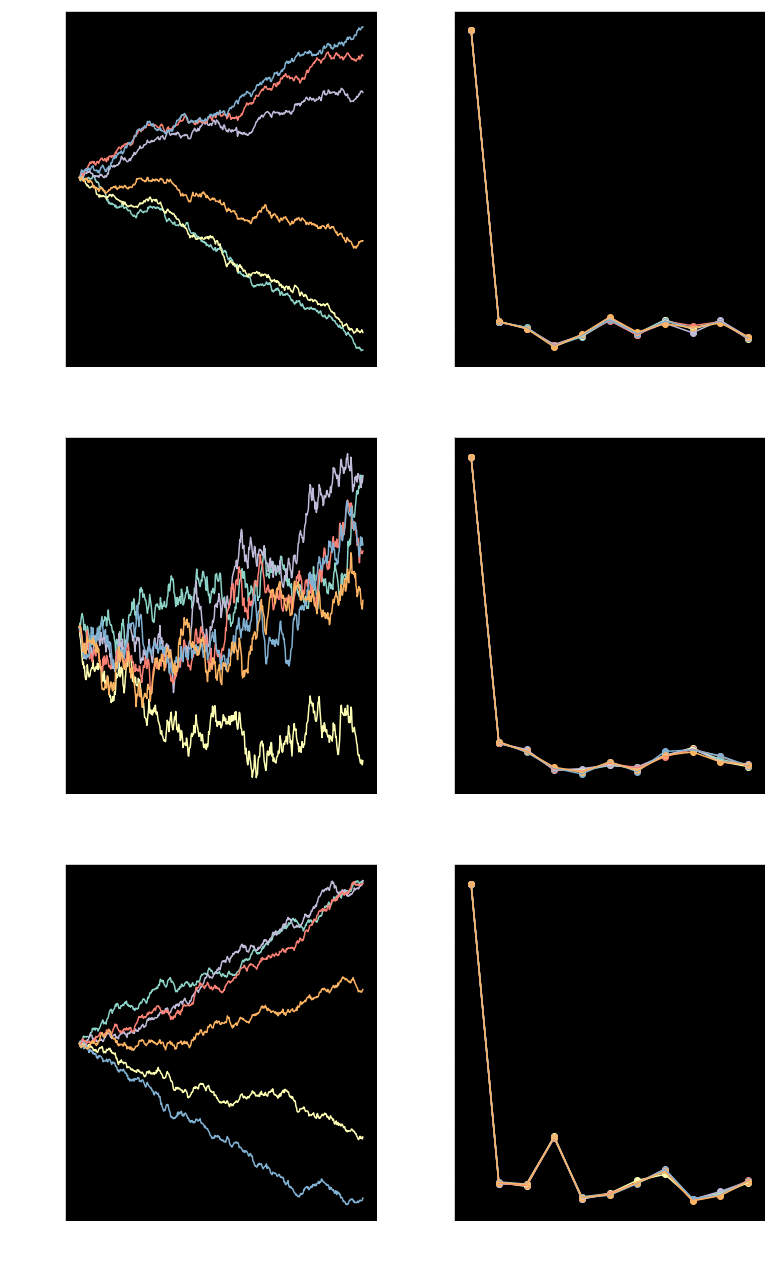

In [5]:
fig, axes = plt.subplots(nrows=3, ncols=2)
xs = range(LAGS+1)

drifts = [-5.0, 0.0, 5.0]

X = BM(x0=100, T=T, scheme_steps=SCHEME_STEPS, vol=1,\
           barrier=0, barrier_condition='absorb')

for i, ax_row in enumerate(axes):
    drift = drifts[i]
    X.drift_double = drift
    df_origin = X.simulate()
    dfs = [df_origin] + [RPRG(df_origin) for _ in range(N_SURRROGATE)]
    
    for df in dfs:
        ax = ax_row[0]
        df.plot(kind='line', ax=ax, legend=False)
        ax.set_xlabel('time\ndrift={:.2f}'.format(drift))
        ax.set_ylabel('spot')

        ax = ax_row[1]
        rets = ((df-df.shift(1))/df.shift(1)).iloc[1:]
        ys = acf(rets, nlags=LAGS)
        ax.plot(xs, ys)
        ax.scatter(xs, ys, marker='o')
    
        ax.set_xlabel('lag')
        ax.set_ylabel('autocorrelogram')
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x)))

plt.tight_layout()
plt.show()

## Vasicek model

Again, scrambling the phase of returns in Fourier space does not affect the autocorrelogram. The resulting sample paths are similar in frequency and volatility, although their drift have changed.

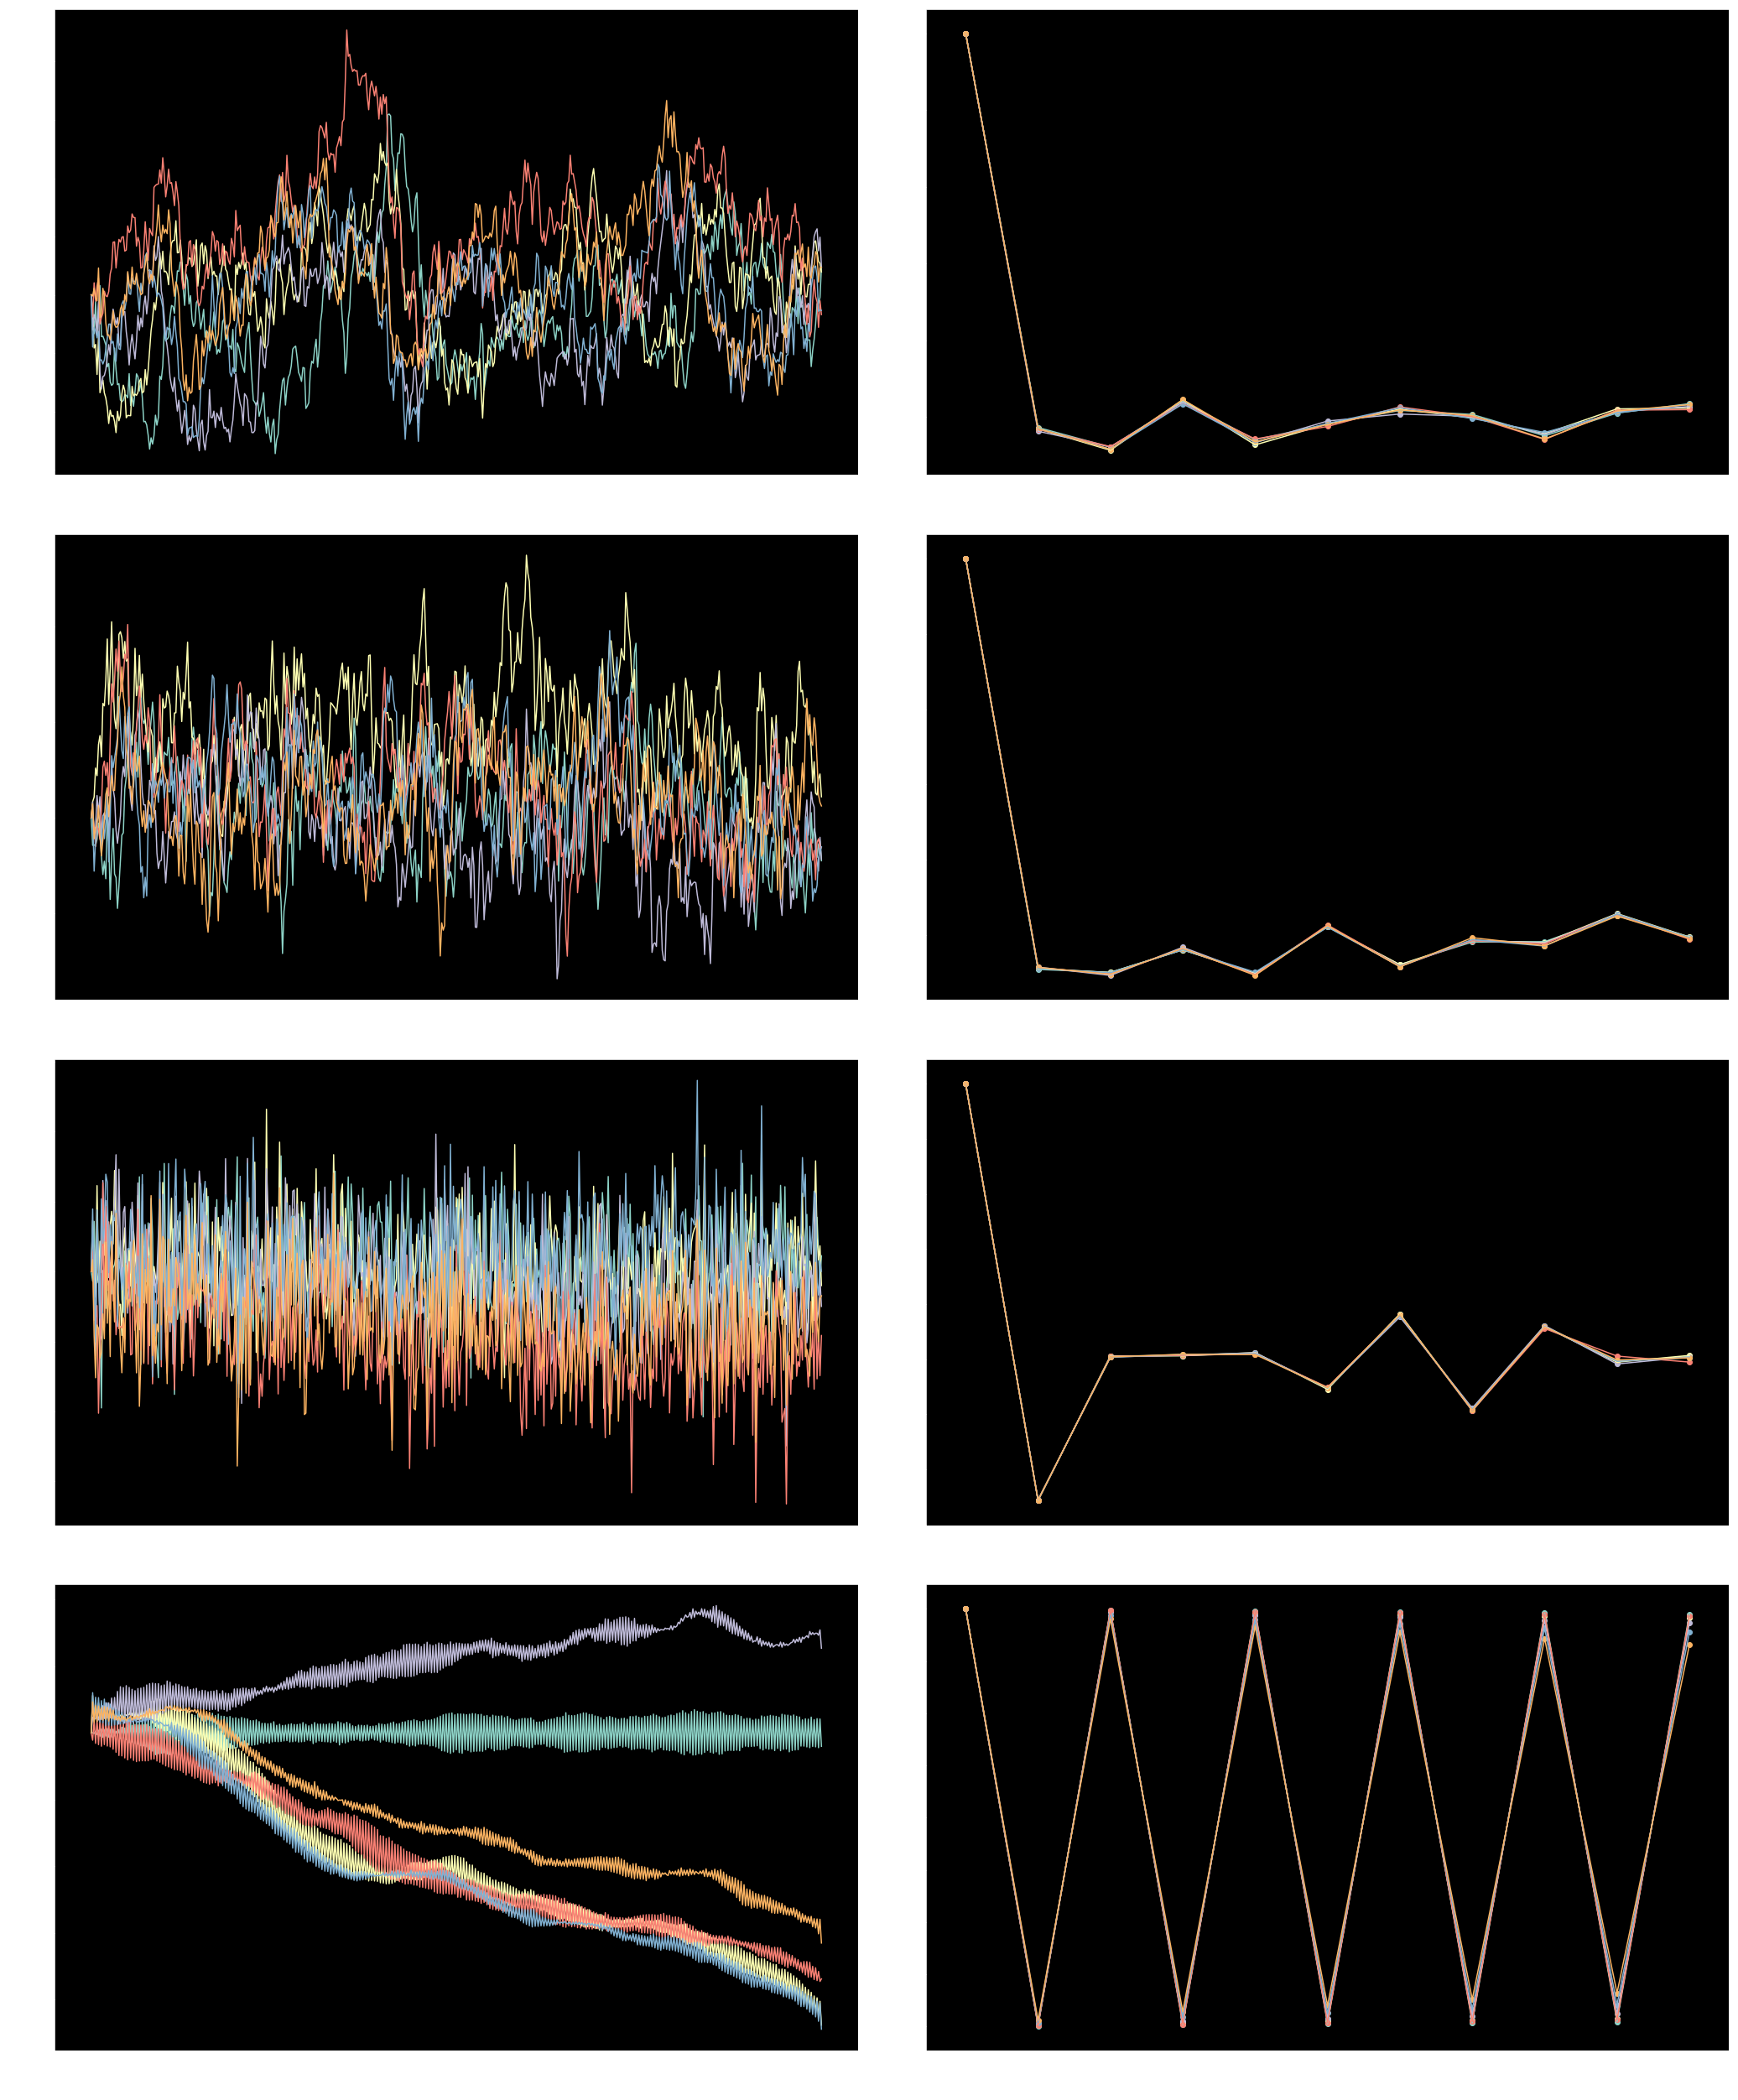

In [6]:
fig, axes = plt.subplots(figsize=(29, 35), nrows=4, ncols=2)
xs = range(LAGS+1)

mean_reversions = [1.0, 1e1, 5e1, 1e2]

X = Vasicek(x0=100, T=10, scheme_steps=SCHEME_STEPS, vol=1,\
            long_term=100,\
            barrier=0, barrier_condition='absorb')

for i, ax_row in enumerate(axes):
    mean_reversion = mean_reversions[i]
    X.mean_reversion = mean_reversion
    df_origin = X.simulate()
    dfs = [df_origin] + [RPRG(df_origin) for _ in range(N_SURRROGATE)]
    
    for df in dfs:
        ax = ax_row[0]
        df.plot(kind='line', ax=ax, legend=False)
        ax.set_xlabel('time\nmean reversion={:.2f}'.format(mean_reversion))
        ax.set_ylabel('spot')

        ax = ax_row[1]
        rets = ((df-df.shift(1))/df.shift(1)).iloc[1:]
        ys = acf(rets, nlags=LAGS)
        ax.plot(xs, ys)
        ax.scatter(xs, ys, marker='o')
    
        ax.set_xlabel('lag')
        ax.set_ylabel('autocorrelogram')
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x)))

plt.tight_layout()
plt.show()

## Fractional Brownian motion

* $H=\frac{1}{2}$ : Brownian motion
* $H<\frac{1}{2}$ : mean-reverting, rougher sample paths
* $H>\frac{1}{2}$ : trend-following, smoother sample paths

Again, scrambling the phase of returns in Fourier space does not affect the autocorrelogram. The resulting sample paths are similar in roughness and volatility, although their drift have changed.

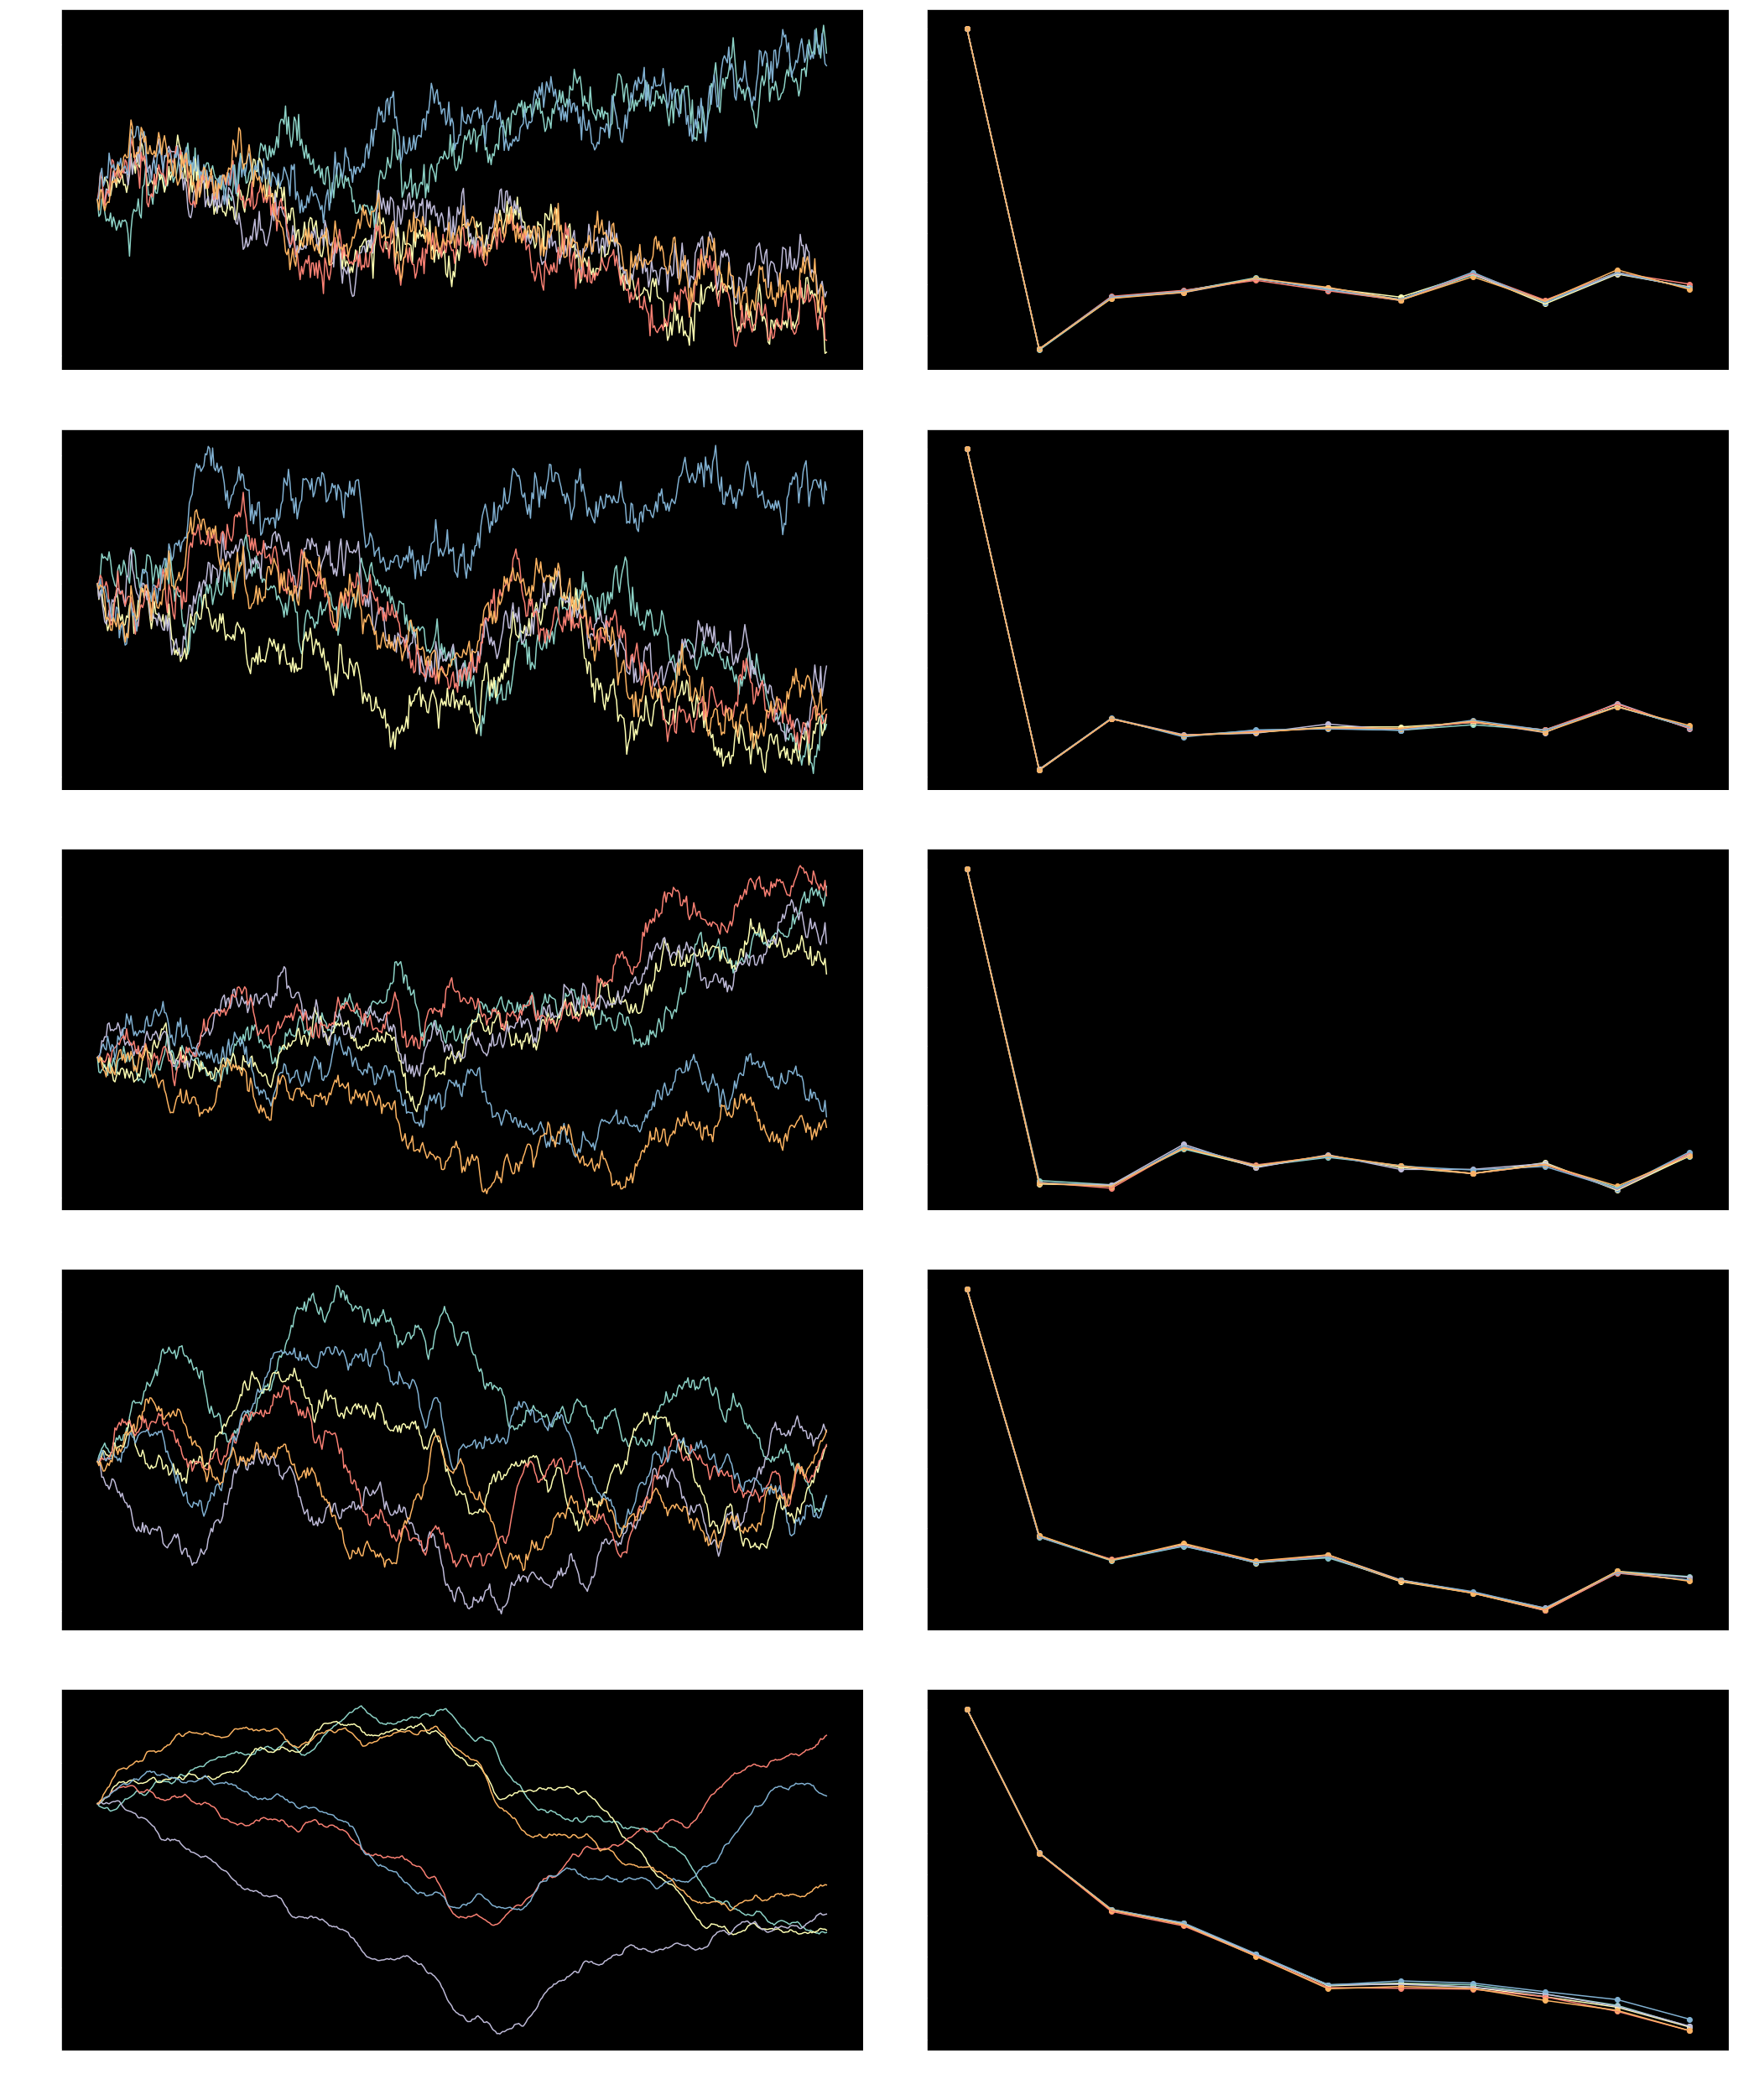

In [7]:
fig, axes = plt.subplots(figsize=(29, 35), nrows=5, ncols=2)
xs = range(LAGS+1)

Hs = [0.3, 0.4, 0.5, 0.6, 0.9]

X = FBM(x0=100, T=T, scheme_steps=SCHEME_STEPS, drift=0, vol=1)

for i, ax_row in enumerate(axes):
    H = Hs[i]
    X.H = H
    df_origin = X.simulate()
    dfs = [df_origin] + [RPRG(df_origin) for _ in range(N_SURRROGATE)]
    
    for df in dfs:
        ax = ax_row[0]
        df.plot(kind='line', ax=ax, legend=False)
        ax.set_xlabel('time\nH={:.2f}'.format(H))
        ax.set_ylabel('spot')

        ax = ax_row[1]
        rets = ((df-df.shift(1))/df.shift(1)).iloc[1:]
        ys = acf(rets, nlags=LAGS)
        ax.plot(xs, ys)
        ax.scatter(xs, ys, marker='o')
    
        ax.set_xlabel('lag')
        ax.set_ylabel('autocorrelogram')
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x)))

plt.tight_layout()
plt.show()